# Studying Bias and Variance in machine learning

These terms have a different meaning to bias and variance in econometrics 

## Bias: 
Underfitting data. The error rate of the model is high.

## Variance: 
Overfitting data. The model's ability to predict out of sample is low despite low in sample error.


Loading things

In [471]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize

### 1.1 Visualising the dataset

We will begin by visualizing the dataset containing historical records on the change in the water level, x, and the amount of water flowing out of the dam, y.

This dataset is divided into three parts:
+ A training set that your model will learn on: X, y
+ A cross validation set for determining the regularization parameter: Xval, yval
+ A test set for evaluating performance. These are “unseen” examples which your model did not see during training: Xtest, ytest

In [472]:
data = loadmat('ex5data1.mat')
X_0 = data['X']
X_0_test = data['Xtest']
X_0_val = data['Xval']
y = data['y']
y_test = data['ytest']
y_val = data['yval']
# initialising thetas
theta_0 = np.ones((2,1))

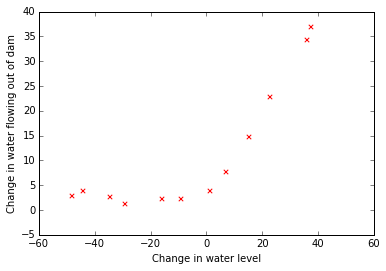

In [473]:
plt.scatter(X_0, y, c = 'r', marker='x')
plt.xlabel('Change in water level')
plt.ylabel('Change in water flowing out of dam')

### 1.2 Regularized linear regression cost function

$J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})^2 \right) + \frac{\lambda}{2m}\left(\sum_{j=i}^n \theta^2_j\right)$

In [474]:
def add_ones(X_0):
    """
    Adds a column of ones to X
    """
    m, n = X_0.shape
    # add a row of ones
    X = np.ones((m, n+1))
    X[:,1:] = X_0
    return X

def predict(X_0, theta):
    """
    Generates a prediction of outcome y given data X and parameters theta
    X_0 is a (m, n) matrix
    y is a (m, 1) matrix
    theta is a (n+1, 1) matrix
    """
    X = add_ones(X_0)
    h_theta = np.dot(X, theta)
    return h_theta

def cost_function(theta, X_0, y, lamda):
    """
    Calculates the cost function for a linear regression
    X_0 is a (m, n) matrix
    y is a (m, 1) matrix
    theta is a (n+1, 1) matrix
    """
    theta = theta.reshape((X_0.shape[1]+1, 1))
    h_theta = predict(X_0, theta)
    dist = h_theta - y
    term1 = np.dot(dist.T, dist) / float(2*m)
    term2 = (lamda / float(2*m)) * np.dot(theta[1:].T, theta[1:])
    return (term1 + term2)[0][0]
    
    

In [475]:
cost_function(theta_0, X_0, y, 0.0)

303.95152555359761

### 1.3 Regularized linear regression gradient

$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x^{(i)}$ for $j=0$

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \left( \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x^{(i)} \right) + \frac{\lambda}{m}\theta_j$ for $1 \leq j$

In [476]:
def cost_gradient(theta, X_0, y, lamda):
    """
    Calculates the gradient of the cost function
    """
    theta = theta.reshape((X_0.shape[1]+1, 1))
    h_theta = predict(X_0, theta)
    dist = h_theta - y
    X = add_ones(X_0)
    term1 = np.dot(dist.T, X) / float(m)
    term2 = (lamda / float(m)) * theta_0[1:]
    grad = term1[0]
    grad[1:] += term2
    return grad.flatten()

In [479]:
cost_gradient(theta_0, X_0, y, 1.0)

array([ -15.30301567,  598.25074417])

### 1.4 Fitting linear regression

In [478]:
lamda = 0.0
theta_0 = np.ones((2, 1)).reshape(-1)
theta_opt = minimize(
    cost_function, x0=theta_0, args=(X_0, y, lamda), method='CG', jac=cost_gradient, 
    options={"maxiter":200, "disp":True}).x
theta_opt

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


array([ 13.08790734,   0.36777925])

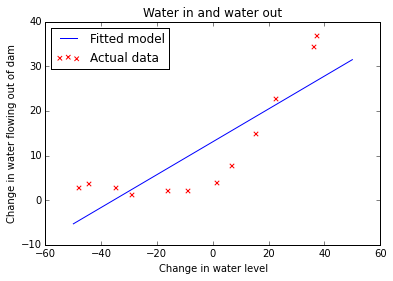

In [480]:
x_domain = np.linspace(-50, 50, 1001)
plt.plot(x_domain, theta_opt[0] + theta_opt[1] * x_domain, label='Fitted model')
plt.scatter(X_0, y, c = 'r', marker='x', label='Actual data')
plt.xlabel('Change in water level')
plt.ylabel('Change in water flowing out of dam')
plt.title('Water in and water out')
plt.legend(loc=2)

## 2 Bias-variance

### 2.1 Learning curves

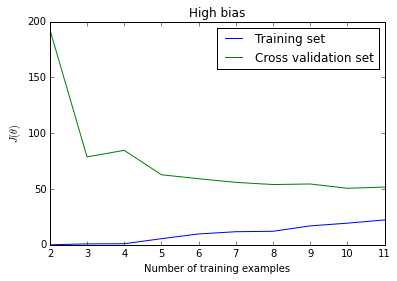

In [481]:
error_train = []
error_val = []

lamda = 0.0
for i in range(2,m): 
    theta_0 = np.ones((2, 1)).reshape(-1)
    j_train = minimize(
    cost_function, x0=theta_0, args=(X_0[:i], y[:i], lamda), method='CG', jac=cost_gradient, 
    options={"maxiter":200, "disp":False})
    error_train.append(j_train.fun)
    j_val = cost_function(j_train.x, X_0_val, y_val, lamda)
    error_val.append(j_val)

plt.plot(range(2,m), error_train, label='Training set')
plt.plot(range(2,m), error_val, label='Cross validation set')
plt.title('High bias')
plt.ylabel(r'$J(\theta)$')
plt.xlabel('Number of training examples')
plt.legend(loc=1)

##3 Polynomial regression

In [482]:
def poly_features(X_0, p):
    X = np.ones((X_0.shape[0], p))
    X[:,0] = X_0.flatten()
    for j in range(1, p):
        X[:,j] = X[:,0]**(j+1)
    return X

### 3.1 Learning Polynomial Regression

In [483]:
def feature_normalise(X_0):
    X_p = np.zeros(X_0.shape)
    mu = []
    sigma = []
    for j in range(0, X_0.shape[1]):
        mean_j = np.mean(X_0[:,j])
        std_j = np.std(X_0[:,j])
        X_p[:,j] = (( X_0[:,j] - mean_j) / std_j)
        mu.append(mean_j)
        sigma.append(std_j)
    return X_p, mu, sigma

Optimization terminated successfully.
         Current function value: 0.028892
         Iterations: 73
         Function evaluations: 76
         Gradient evaluations: 76


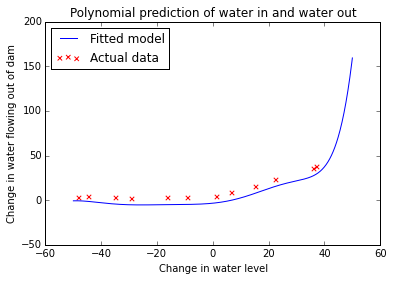

In [514]:
p = 8
X_p, mu, sigma = feature_normalise(poly_features(X_0,p))
lamda = 0.0
theta_0 = np.zeros((p+1, 1)).reshape(-1)
theta_opt = minimize(
    cost_function, x0=theta_0, args=(X_p, y, lamda), method='BFGS', jac=cost_gradient, 
    options={"maxiter":100, "disp":True}).x
theta_opt

x_domain_p = feature_normalise(poly_features(x_domain, p))[0]
theta_0 = theta_opt[0]
theta_opt = theta_opt[1:]
prediction = theta_0 + np.dot(x_domain_p, theta_opt.reshape(p,1))
plt.plot(x_domain, prediction, label='Fitted model')
plt.scatter(X_0, y, c = 'r', marker='x', label='Actual data')
plt.xlabel('Change in water level')
plt.ylabel('Change in water flowing out of dam')
plt.title('Polynomial prediction of water in and water out')
plt.legend(loc=2)

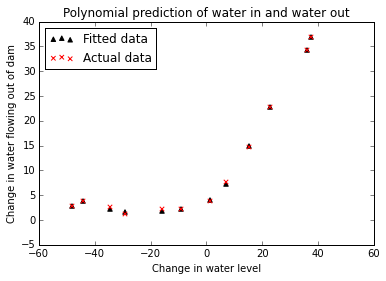

In [515]:
prediction_p = theta_0 + np.dot(X_p, theta_opt.reshape(p,1))
plt.scatter(X_0, prediction_p, c = 'k', marker='^', label='Fitted data')
plt.scatter(X_0, y, c = 'r', marker='x', label='Actual data')
plt.xlabel('Change in water level')
plt.ylabel('Change in water flowing out of dam')
plt.title('Polynomial prediction of water in and water out')
plt.legend(loc=2)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 14
         Current function value: 2.401540
         Iterations: 1
         Function evaluations: 14
         Gradient evaluations: 2
         Current function value: 0.000125
         Iterations: 46
         Function evaluations: 87
         Gradient evaluations: 75
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 229
         Function evaluations: 399
         Gradient evaluations: 399
         Current function value: 0.049829
         Iterations: 66
         Function evaluations: 149
         Gradient evaluations: 137
Optimization terminated successfully.
         Current function value: 0.056714
   

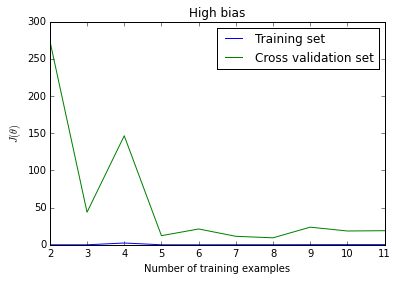

In [519]:
p = 5
lamda = 0.0
X_p, mu, sigma = feature_normalise(poly_features(X_0,p))
X_p_val, mu, sigma = feature_normalise(poly_features(X_val,p))
error_train = []
error_val = []

for i in range(2,m): 
    theta_0 = np.zeros((p+1, 1)).reshape(-1)
    j_train = minimize(
        cost_function, x0=theta_0, args=(X_p[:i,:], y[:i], lamda), method='CG', jac=cost_gradient, 
        options={"maxiter":1000, "disp":True})
    error_train.append(j_train.fun)
    j_val = cost_function(j_train.x, X_p_val, y_val, lamda)
    error_val.append(j_val)

plt.plot(range(2,m), error_train, label='Training set')
plt.plot(range(2,m), error_val, label='Cross validation set')
plt.title('High bias')
plt.ylabel(r'$J(\theta)$')
plt.xlabel('Number of training examples')
plt.legend(loc=1)